In [1]:
import torch, pickle, random
from torch import nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from vit.vit import SingleDecoderSigmoid
from sklearn.linear_model import LinearRegression

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
with open("beh.pkl", "rb") as f:
    beh = pickle.load(f)
with open("lfp.pkl", "rb") as f:
    lfp = pickle.load(f)

In [4]:
def movave(x, length=20):
    t, n = x.shape
    s = x[:length, :].sum(axis=0)
    c = length
    save = np.zeros_like(x)
    for ti in range(t):
        if ti + length < t:
            s += x[ti+length, :]
            c += 1
        if ti - length - 1 >= 0:
            s -= x[ti - length - 1, :]
            c -= 1
        save[ti, :] = s[:] / c
    return save

In [5]:
sleep_target = [movave(li) for li in lfp]

In [6]:
waves = [2, 6, 10, 22, 55, 170]
for mi in range(5):
    t, n = sleep_target[mi].shape
    tmp = sleep_target[mi] - np.hstack([movave(sleep_target[mi][:, i:i+1], int(min((t - 1) / 2, 20000 / waves[i]))) for i in range(n)])
    sleep_target[mi] = np.array(tmp)

In [7]:
for mi in range(5):
    for li in range(6):
        st = sleep_target[mi][:, li]
        m = st.mean()
        s = st.std()
        st = ((st - m) / s + 3) / 6
        st[st > 1] = 1
        st[st < 0] = 0
        sleep_target[mi][:, li] = st[:]

In [8]:
for mi in range(5):
    sleep_target[mi][:, 0][sleep_target[mi][:, 0] > 0.4] = 1
    sleep_target[mi][:, 0][sleep_target[mi][:, 0] <= 0.4] = 0
    sleep_target[mi][:, 1:][sleep_target[mi][:, 1:] > 0.5] = 1
    sleep_target[mi][:, 1:][sleep_target[mi][:, 1:] <= 0.5] = 0

In [9]:
thickness = [20, 30, 60]
awake_target = []
for mi in range(5):
    at_s = []
    for di in range(2):
        n = len(beh[mi][di])
        at_ss = np.zeros((n, 4))
        for oi in range(3):
            tmp = beh[mi][di][:, oi].copy()
            for i in range(n):
                if beh[mi][di][i, oi] == 1:
                    tmp[max(i-thickness[oi], 0):min(i+thickness[oi], n)] = 1
            at_ss[:, oi] = tmp
        at_ss[:, 3] = beh[mi][di][:, 5] > 20
        at_s.append(at_ss)
    awake_target.append(at_s)

In [10]:
x = []
for mi in range(5):
    x_mouse = []
    x_mouse.append(pd.read_csv(f"../process_data/Nomoto_mPFC/z_score/mouse{mi+1}/mouse{mi+1}_day1.csv", header=None).values)
    x_mouse.append(pd.read_csv(f"../process_data/Nomoto_mPFC/z_score/mouse{mi+1}/mouse{mi+1}_day1_sleep.csv", header=None).values)
    x_mouse.append(pd.read_csv(f"../process_data/Nomoto_mPFC/z_score/mouse{mi+1}/mouse{mi+1}_day2.csv", header=None).values)
    x.append(x_mouse)

In [11]:
for mi in range(5):
    sleep_target[mi] = sleep_target[mi][:x[mi][1].shape[0], :]

In [12]:
def valid_point(inputs, targets):
    t, n = inputs.shape
    im = inputs.mean(axis=0)
    it = targets.mean(axis=0)
    start = int(0.2 * t)
    step = int(0.01 * t)
    width = int(0.1 * t)
    score = np.zeros(50)
    for i in range(50):
        s = start + step * i
        e = s + width
        score[i] = np.square(inputs[s:e].mean(axis=0) - im).mean() + np.square(targets[s:e].mean(axis=0) - it).mean()
    s = start + step * score.argmin()
    return s, s + width

In [13]:
class CLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, output, target):
        return -torch.hstack((torch.log(1 - output[target == 0]), torch.log(output[target == 1]))).mean()

In [14]:
def train(inputs, targets, dim=32, depth=3, length=100, batch_half=32, n_iter=100):
    batch_size = batch_half * 2
    t, n_input = inputs.shape
    _, n_output = targets.shape
    p1, p2 = valid_point(inputs, targets)

    models = []
    loss_trains = []
    loss_valids = []
    for oi in range(n_output):
        loss_train = np.zeros(n_iter)
        loss_valid = np.zeros(n_iter)
        model = SingleDecoderSigmoid(n_input, 1, dim=dim, depth=depth)
        criterion = CLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        for it in range(n_iter):
            model.train()
            optimizer.zero_grad()

            i_data = np.zeros((batch_size, length, n_input))
            t_data = np.zeros((batch_size, length, 1))
            for i, ri in enumerate(np.random.randint(p1 - length + 1, size=batch_half)):
                i_data[i, :, :] = inputs[ri:ri+length, :]
                t_data[i, :, 0] = targets[ri:ri+length, oi]
            for i, ri in enumerate(np.random.randint(p2, t - length + 1, size=batch_half)):
                i_data[i+batch_half, :, :] = inputs[ri:ri+length, :]
                t_data[i+batch_half, :, 0] = targets[ri:ri+length, oi]

            i_data = torch.tensor(i_data).float()
            o_data = model(i_data)
            t_data = torch.tensor(t_data).float()
            loss = criterion(o_data, t_data)
            loss.backward()
            optimizer.step()

            model.eval()
            loss_train[it] = criterion(model(i_data), t_data).item()

            i_data = np.zeros((batch_size, length, n_input))
            t_data = np.zeros((batch_size, length, 1))
            for i, ri in enumerate(np.random.randint(p1, p2 - length + 1, size=batch_size)):
                i_data[i, :, :] = inputs[ri:ri+length, :]
                t_data[i, :, 0] = targets[ri:ri+length, oi]
            i_data = torch.tensor(i_data).float()
            o_data = model(i_data)
            t_data = torch.tensor(t_data).float()
            loss_valid[it] = criterion(o_data, t_data).item()
        models.append(model)
        loss_trains.append(loss_train)
        loss_valids.append(loss_valid)

    return models, loss_trains, loss_valids, (p1, p2)

Mouse 1: (7931, 9736)
Zone


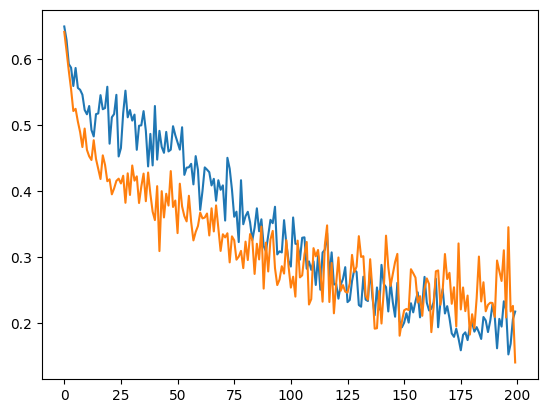

Lick


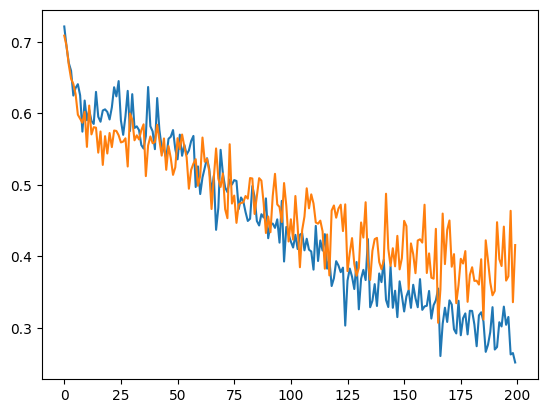

Reward


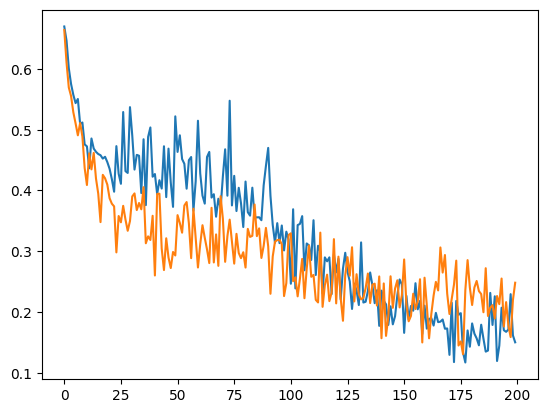

X


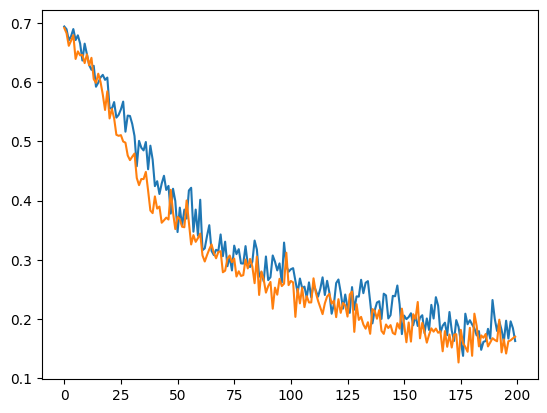

Mouse 2: (10365, 12672)
Zone


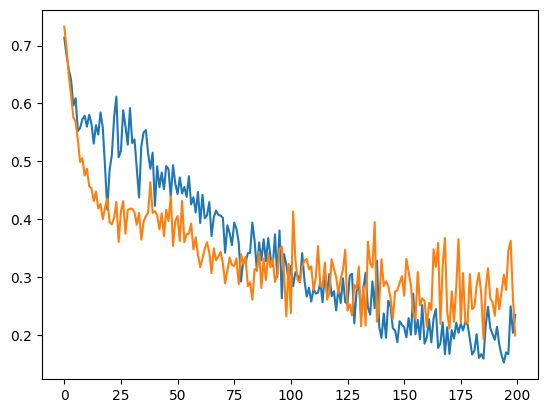

Lick


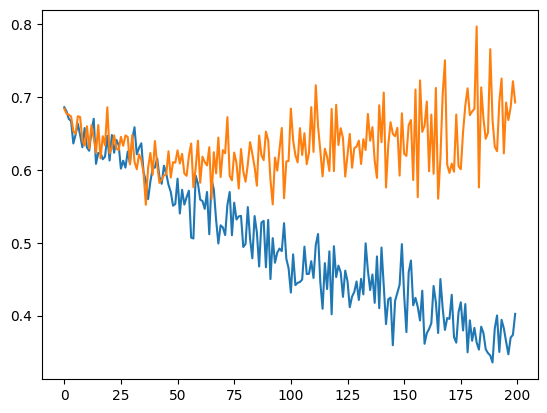

Reward


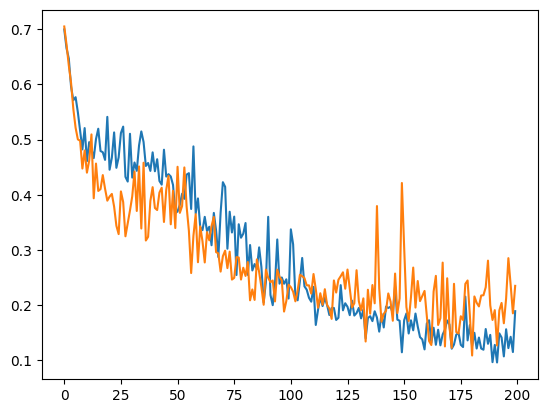

X


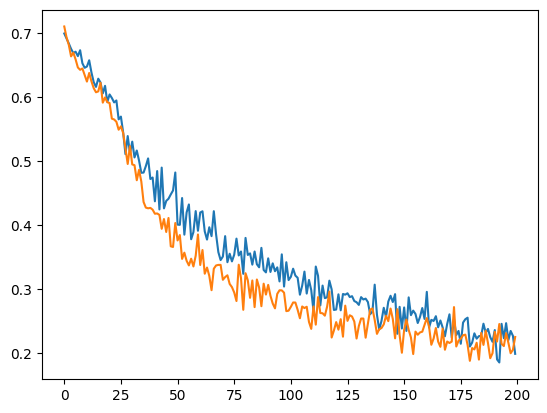

Mouse 3: (6138, 8118)
Zone


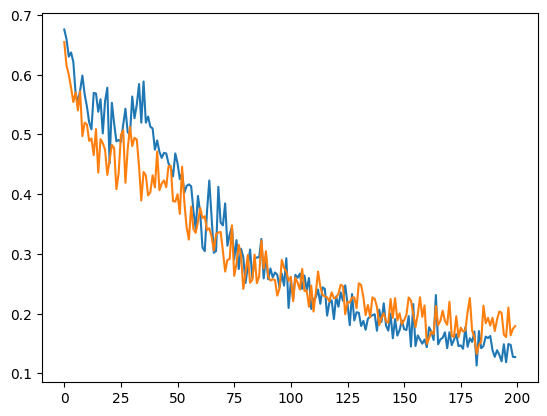

Lick


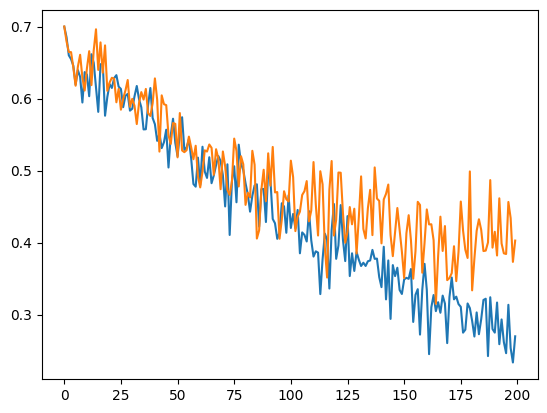

Reward


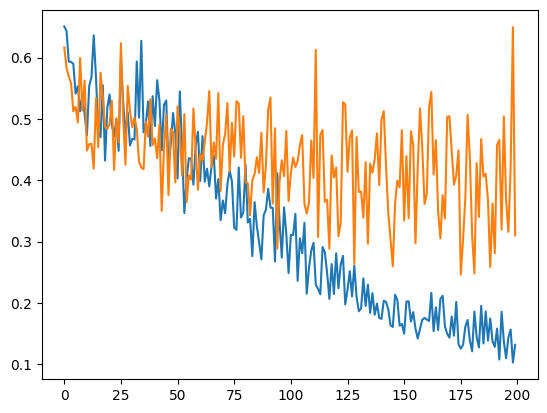

X


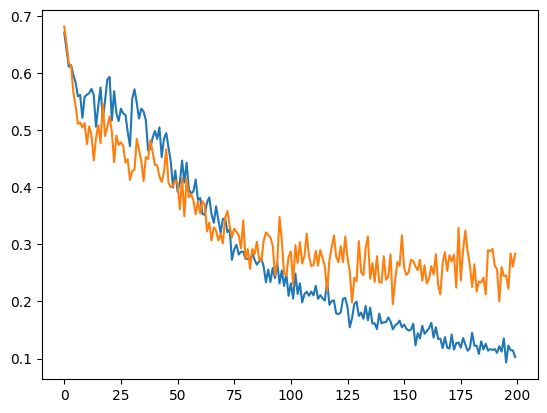

Mouse 4: (8699, 10551)
Zone


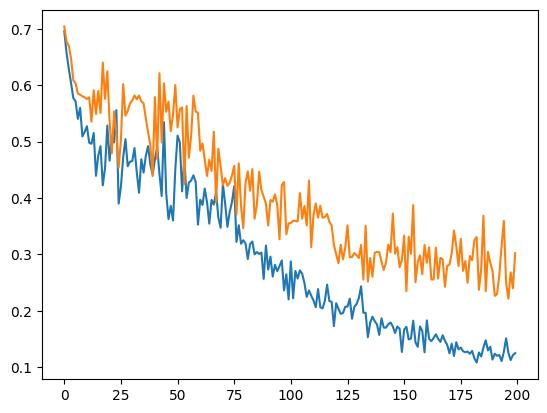

Lick


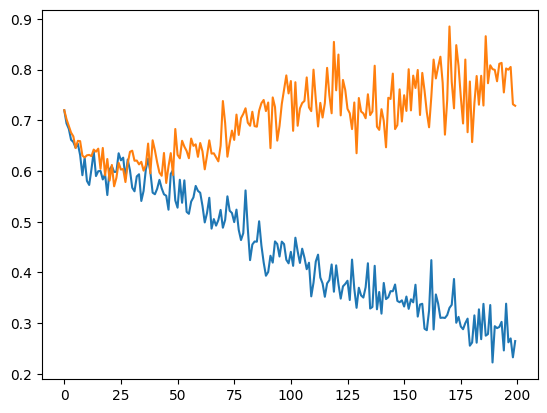

Reward


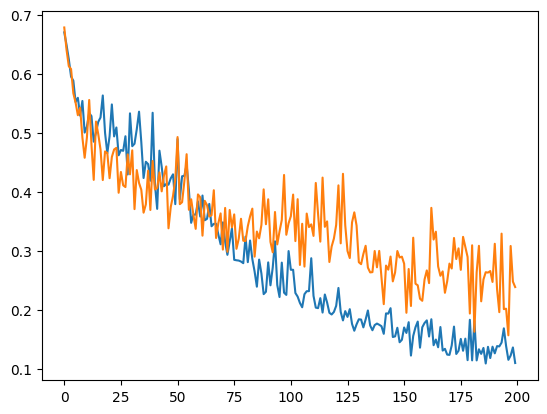

X


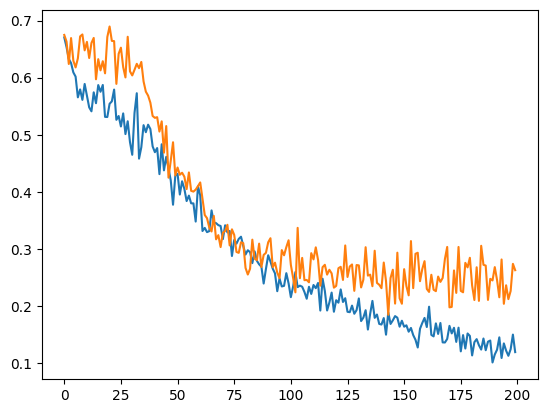

Mouse 5: (9557, 11685)
Zone


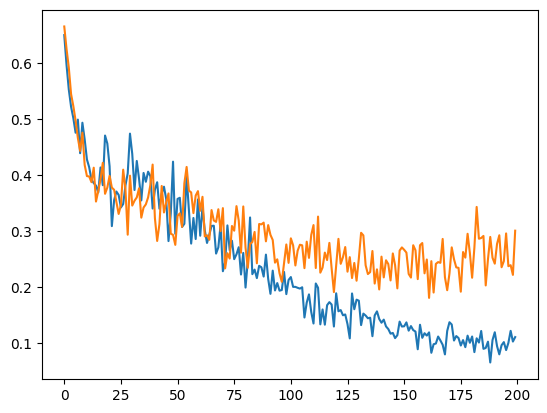

Lick


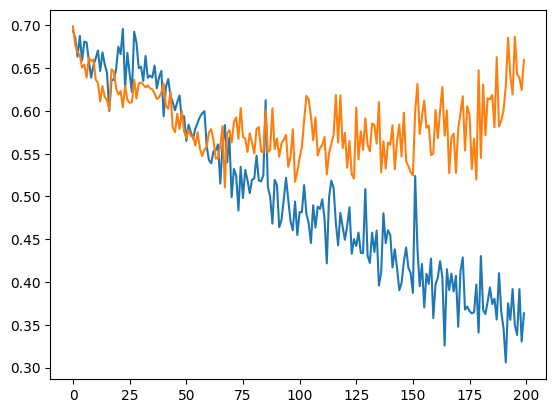

Reward


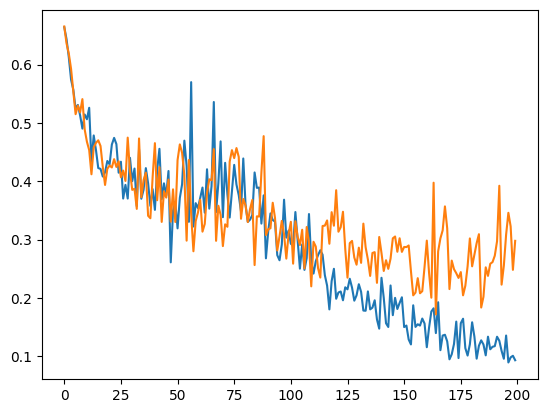

X


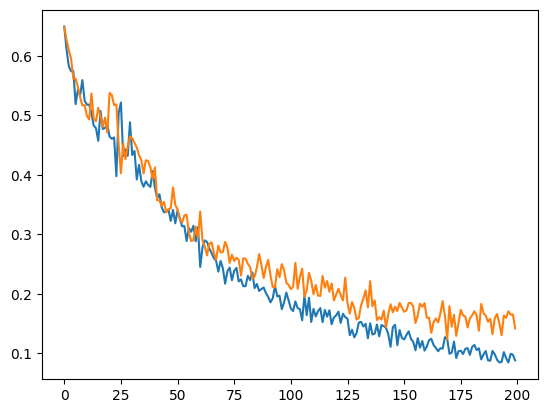

In [15]:
models_list = []
loss_trains_list = []
loss_valids_list = []
ps = []
for mi in range(5):
    models, loss_trains, loss_valids, (p1, p2) = train(x[mi][0], awake_target[mi][0], n_iter=200)
    models_list.append(models)
    loss_trains_list.append(loss_trains)
    loss_valids_list.append(loss_valids)
    
    ps.append((p1, p2))
    print(f"Mouse {mi+1}: ({p1}, {p2})")
    for oi, target in enumerate(["Zone", "Lick", "Reward", "X"]):
        print(target)
        plt.plot(loss_trains[oi])
        plt.plot(loss_valids[oi])
        plt.show()

In [16]:
def embed(model, inputs, length=100, batch_size=64):
    t, n = inputs.shape
    n_iter = (t - length + batch_size) // batch_size
    save = np.zeros((t, model.head.fc2.out_features))
    model.eval()
    for i in range(n_iter):
        bs = min(batch_size, t - length + 1 - i * batch_size)
        i_data = np.zeros((bs, length, n))
        for jj, j in enumerate(range(batch_size * i, batch_size * i + bs)):
            i_data[jj, :, :] = inputs[j:j+length, :]

        o_data = model(torch.tensor(i_data).float()).detach().numpy()
        for jj, j in enumerate(range(batch_size * i, batch_size * i + bs)):
            save[j:j+length, :] += o_data[jj, :, :]

    for i in range(length - 1):
        save[i, :] /= i + 1
        save[-(i+1), :] /= i + 1
    if length > 1:
        save[length-1:-(length-1), :] /= length
    return save

In [17]:
embed_day1 = [[embed(models_list[mi][oi], x[mi][0]) for oi in range(4)] for mi in range(5)]
embed_day2 = [[embed(models_list[mi][oi], x[mi][2]) for oi in range(4)] for mi in range(5)]

Mouse 1: (6351, 7704)
Zone


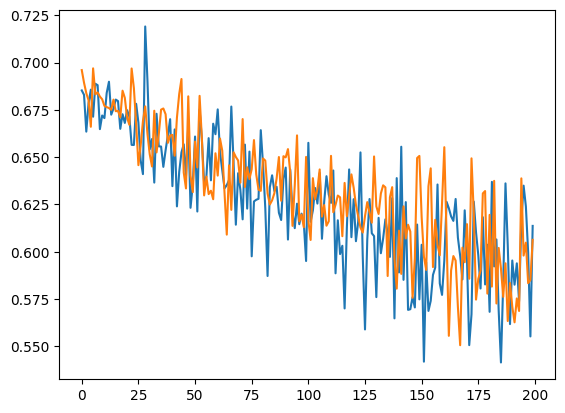

Lick


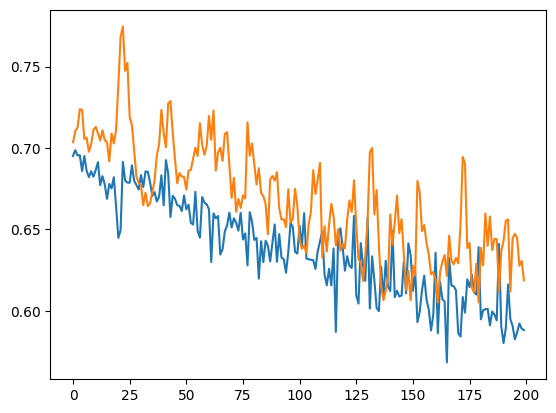

Reward


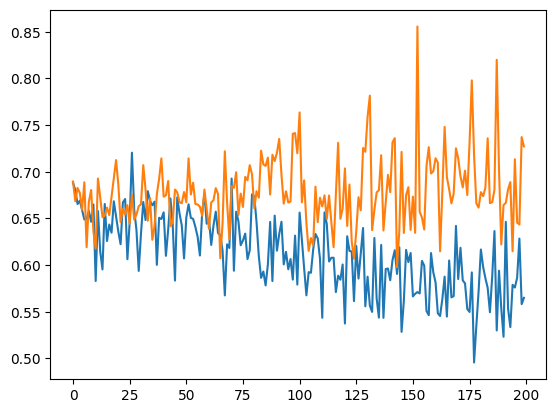

X


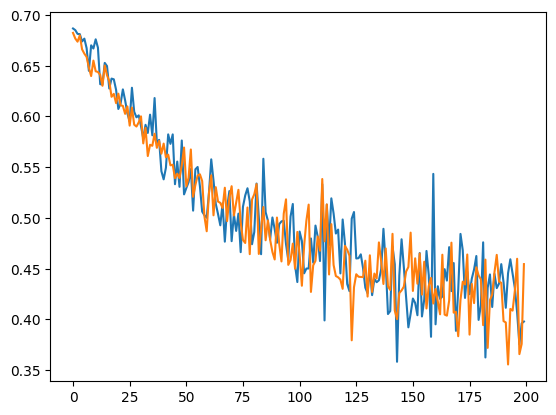

Mouse 2: (7446, 9460)
Zone


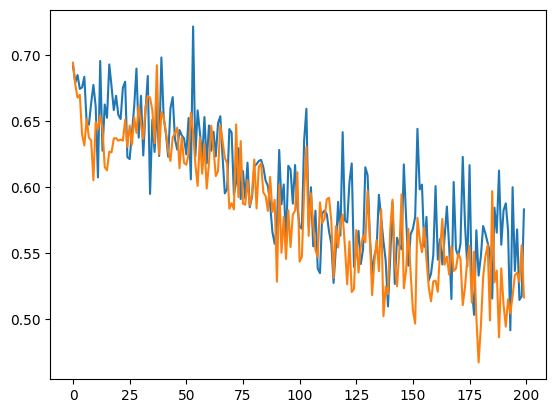

Lick


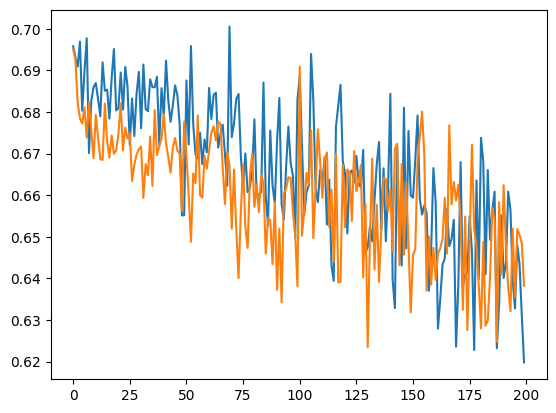

Reward


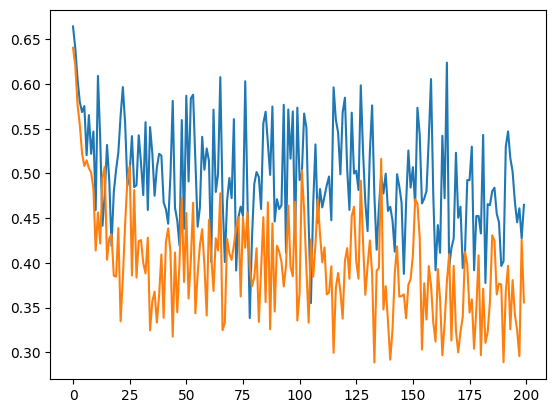

X


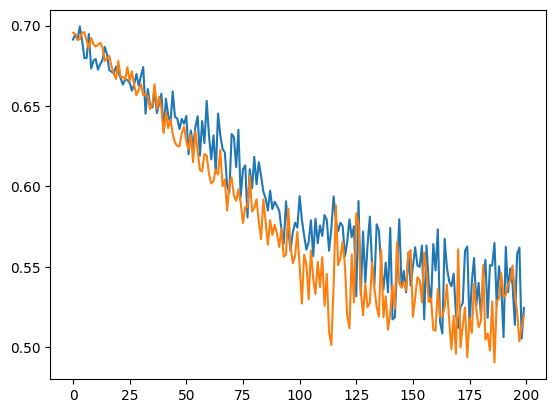

Mouse 3: (9425, 11241)
Zone


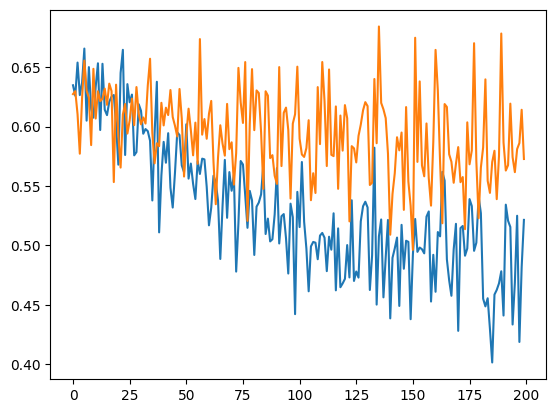

Lick


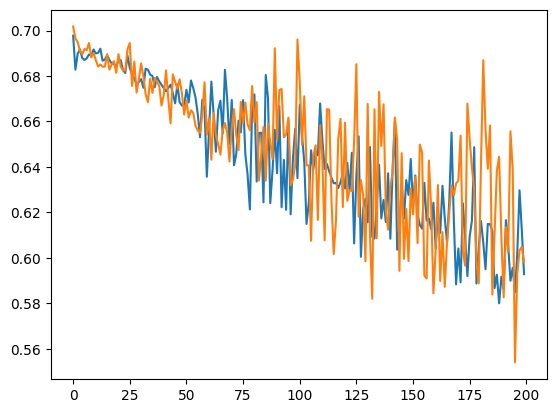

Reward


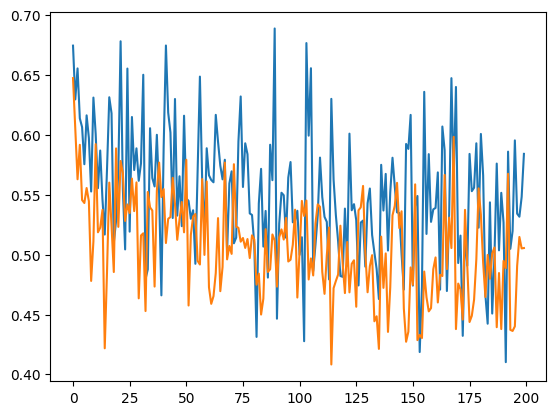

X


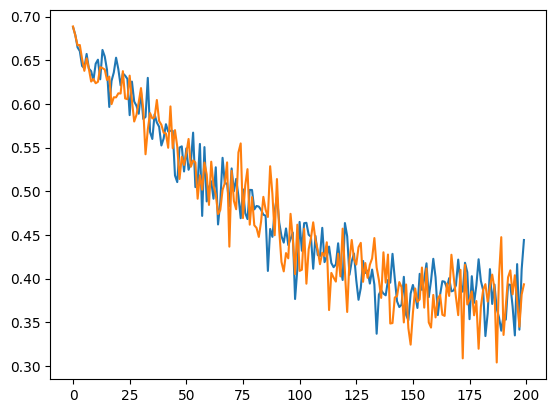

Mouse 4: (7714, 9744)
Zone


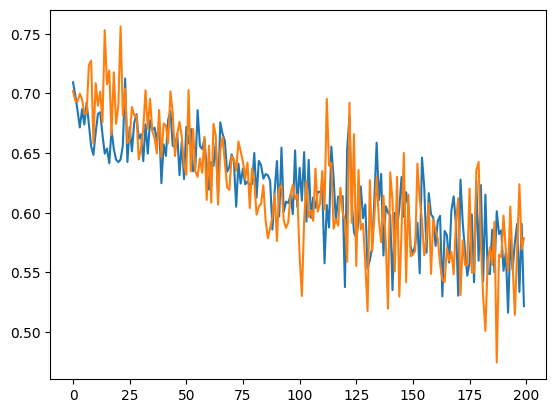

Lick


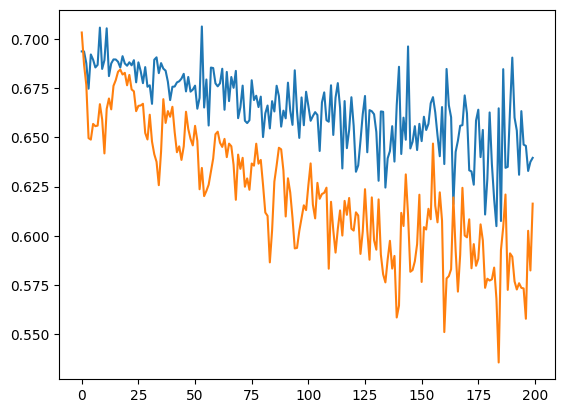

Reward


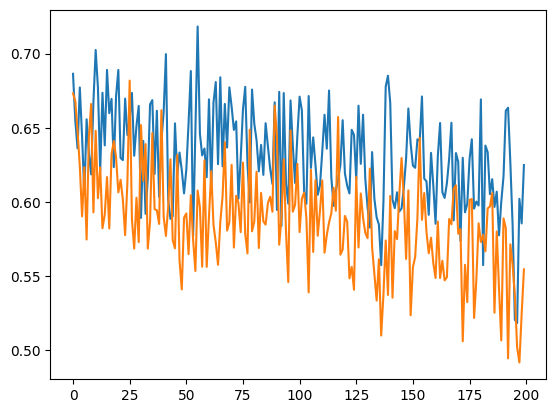

X


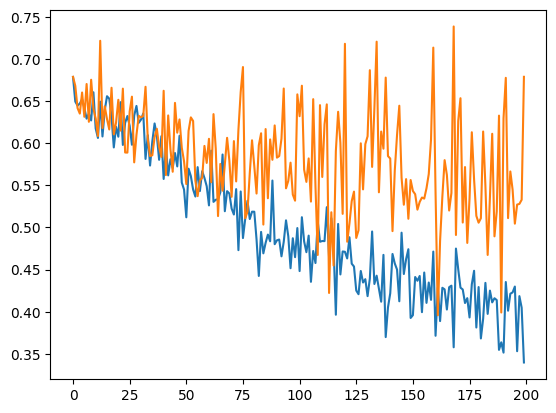

Mouse 5: (7837, 9662)
Zone


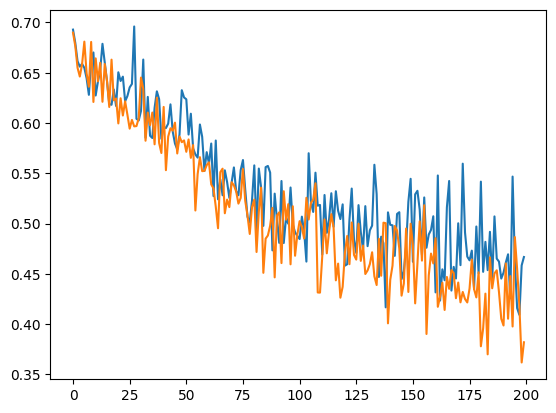

Lick


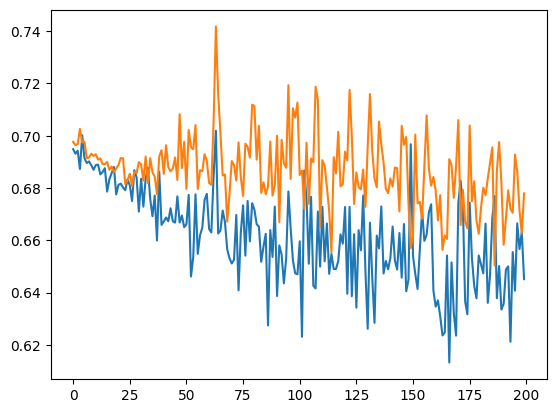

Reward


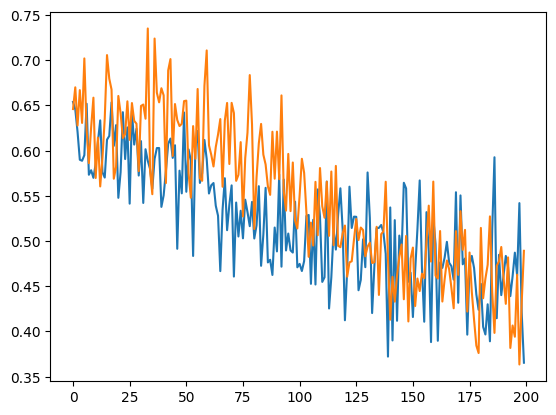

X


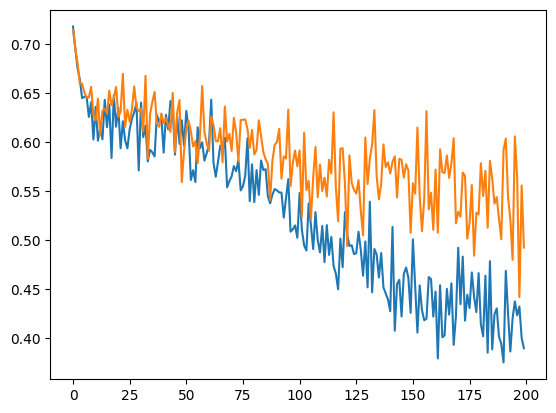

In [18]:
models_list_day2 = []
loss_trains_list_day2 = []
loss_valids_list_day2 = []
ps_day2 = []
for mi in range(5):
    models, loss_trains, loss_valids, (p1, p2) = train(np.hstack(embed_day2[mi]), awake_target[mi][1], n_iter=200)
    models_list_day2.append(models)
    loss_trains_list_day2.append(loss_trains)
    loss_valids_list_day2.append(loss_valids)
    
    ps_day2.append((p1, p2))
    print(f"Mouse {mi+1}: ({p1}, {p2})")
    for oi, target in enumerate(["Zone", "Lick", "Reward", "X"]):
        print(target)
        plt.plot(loss_trains[oi])
        plt.plot(loss_valids[oi])
        plt.show()

In [19]:
embed_day2_tr = [[[embed(models_list_day2[mi][oi], np.hstack(embed_day2[mj])) for oi in range(4)] for mi in range(5)] for mj in range(5)]

Mouse 1: (2852, 3623)
delta


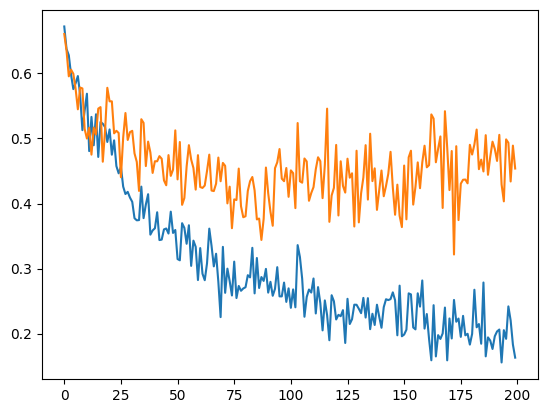

theta


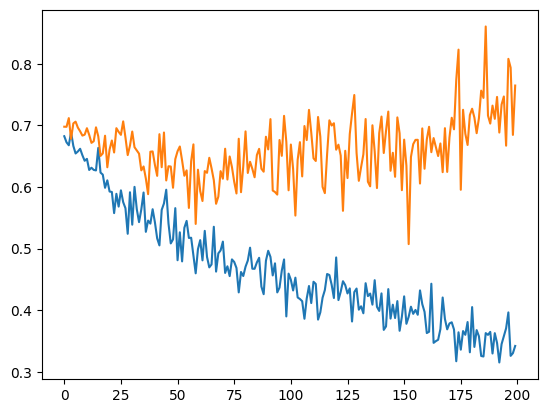

alpha


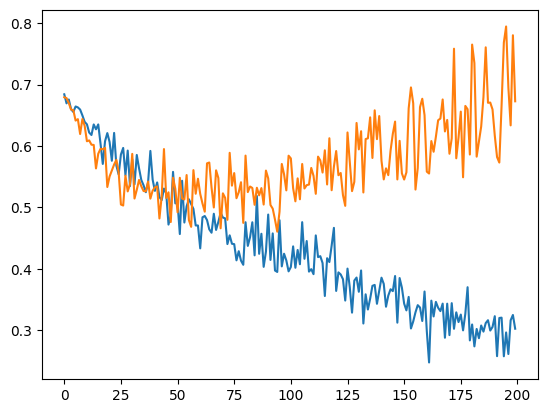

beta


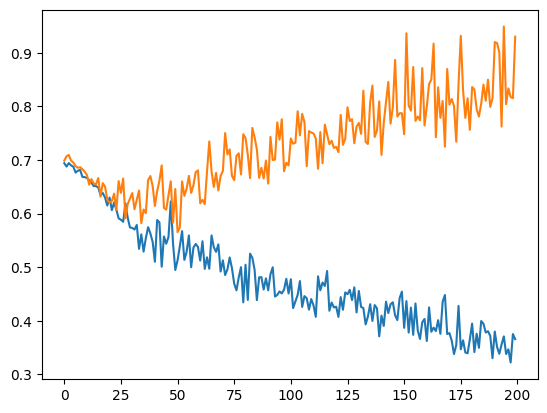

gamma


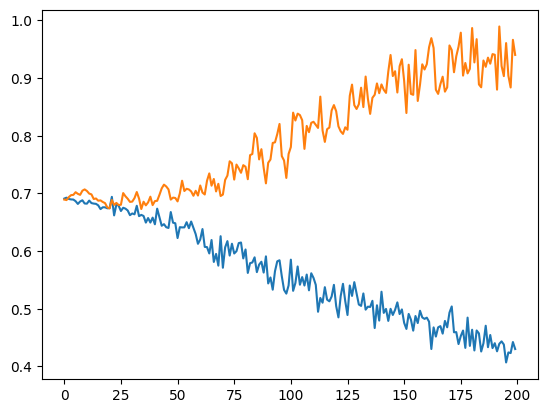

ripple


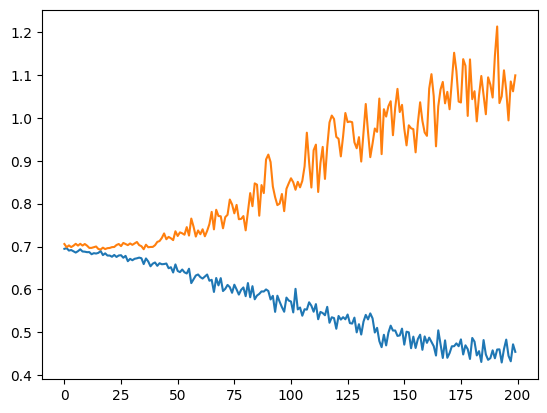

Mouse 2: (1726, 2304)
delta


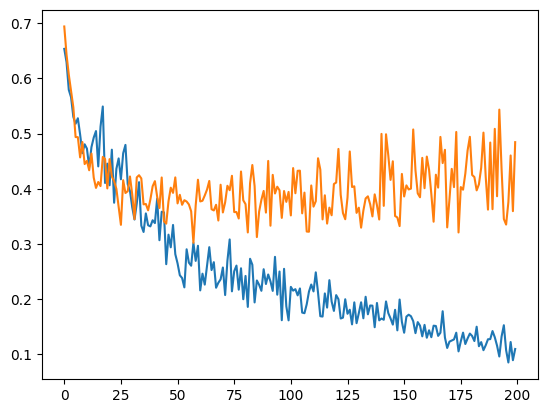

theta


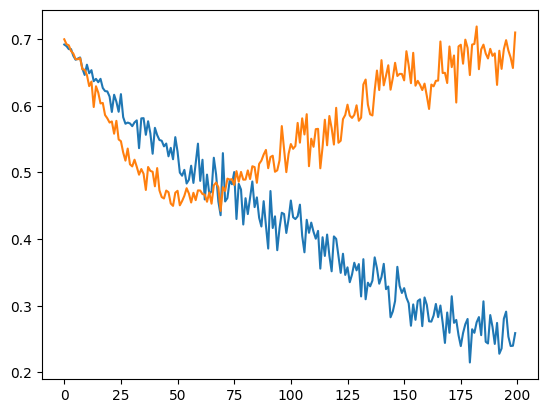

alpha


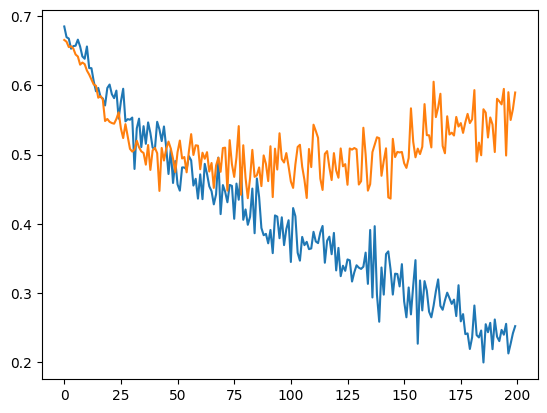

beta


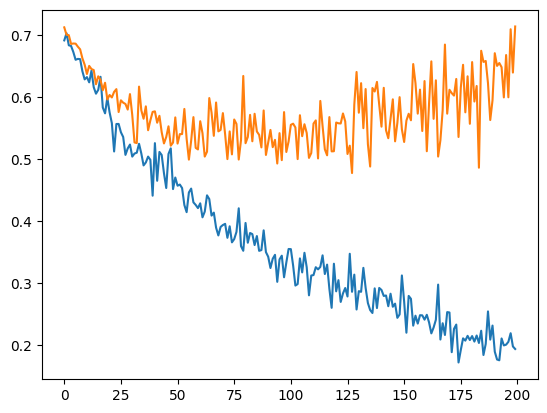

gamma


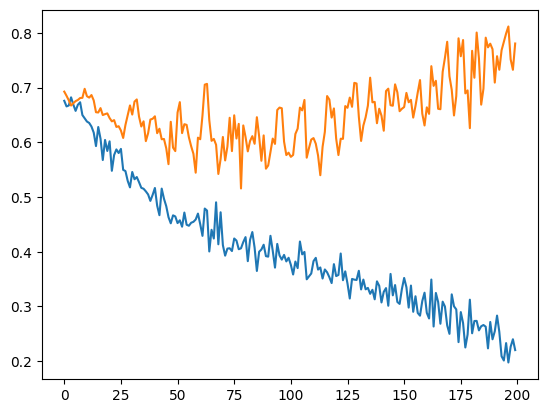

ripple


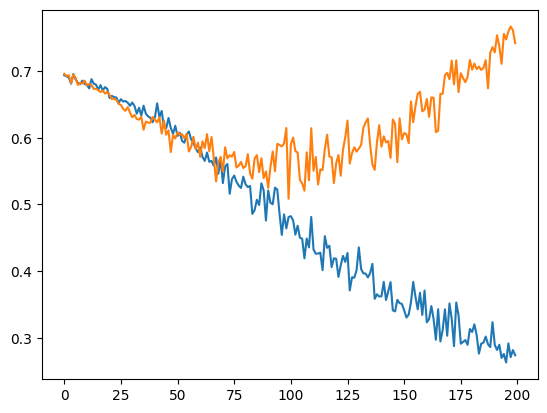

Mouse 3: (6054, 7497)
delta


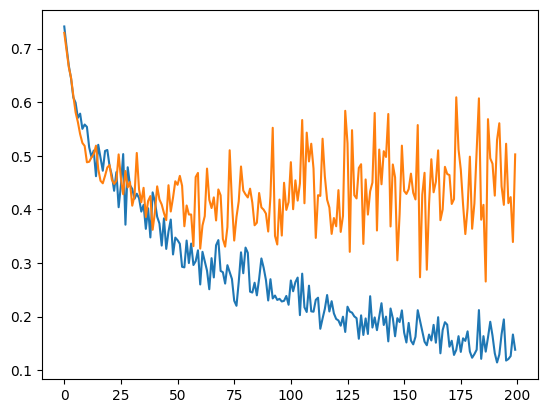

theta


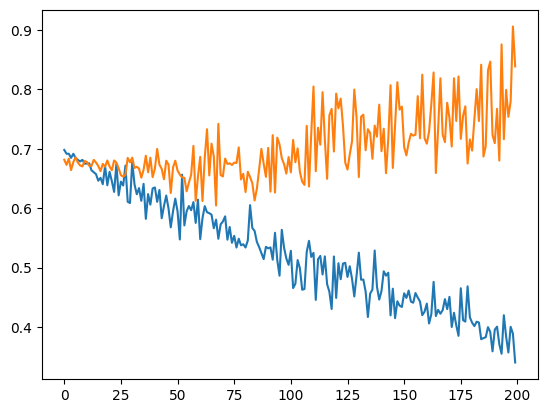

alpha


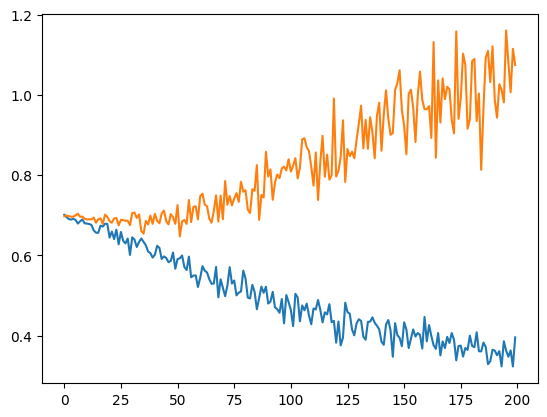

beta


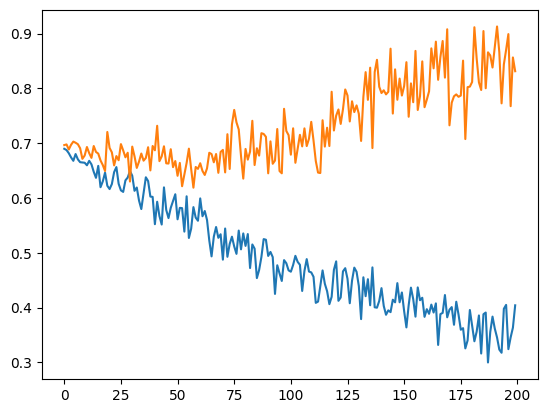

gamma


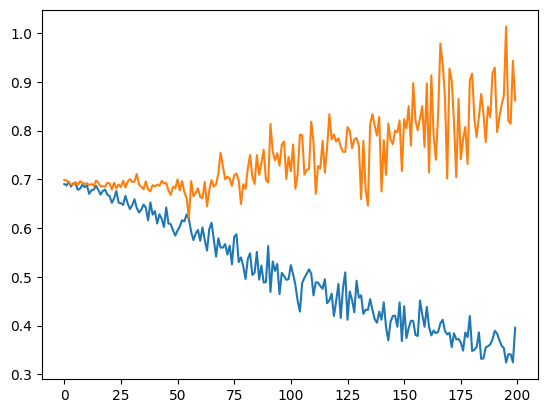

ripple


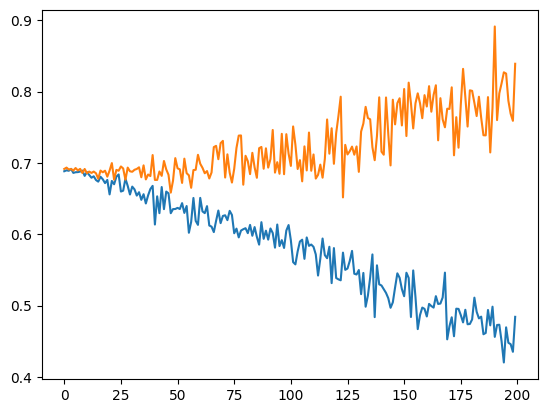

Mouse 4: (5577, 6397)
delta


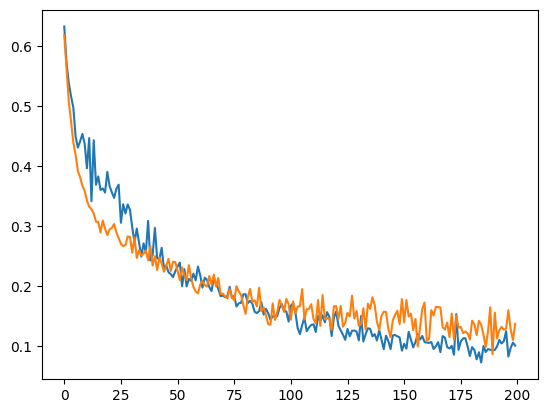

theta


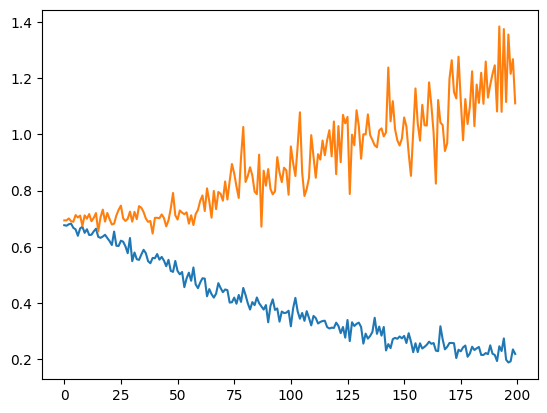

alpha


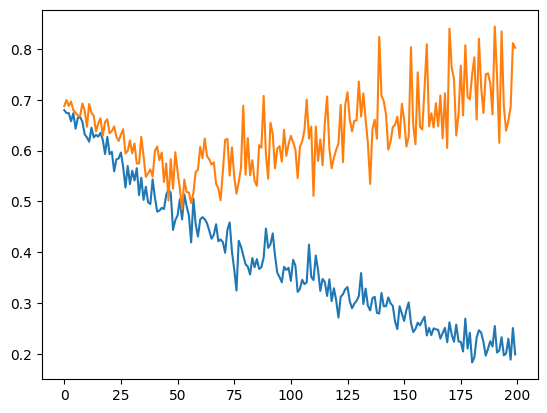

beta


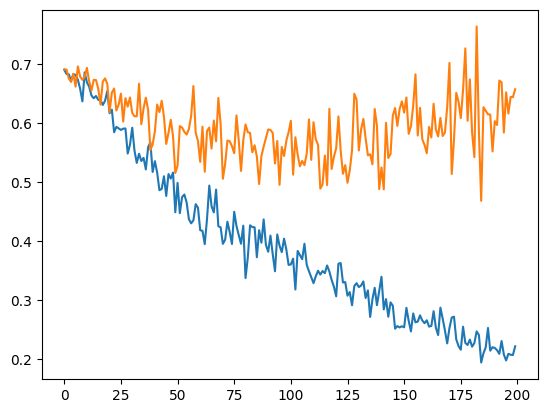

gamma


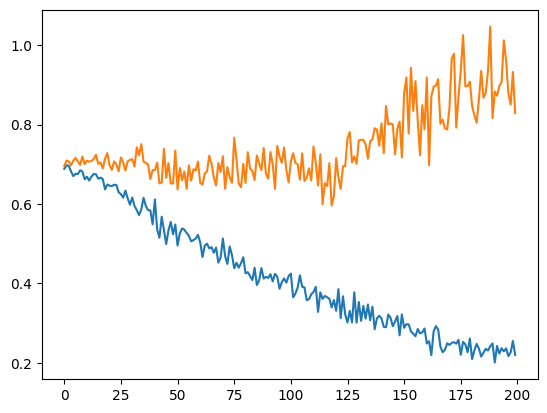

ripple


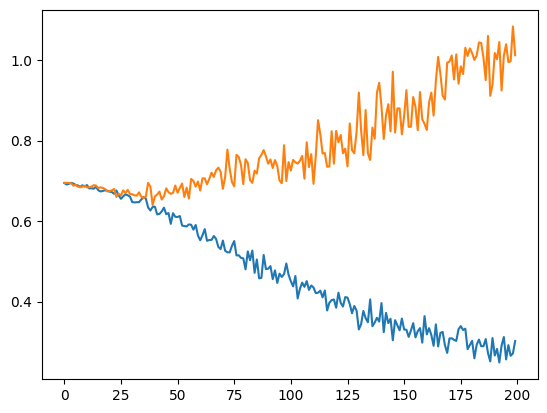

Mouse 5: (1027, 1540)
delta


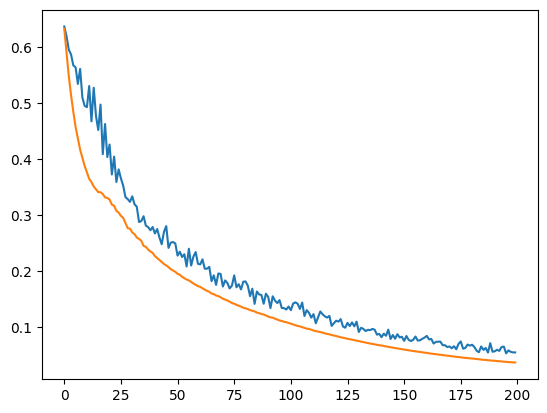

theta


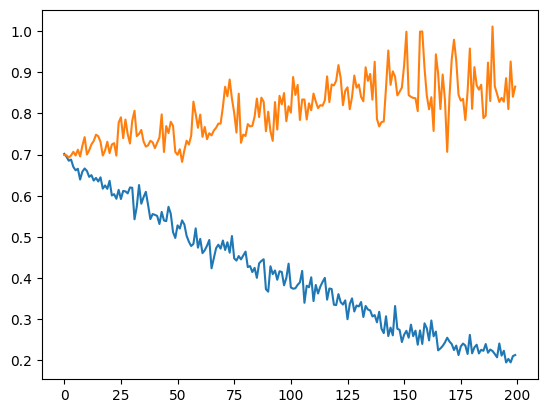

alpha


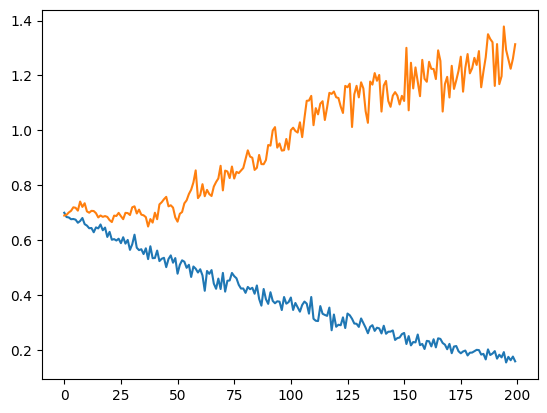

beta


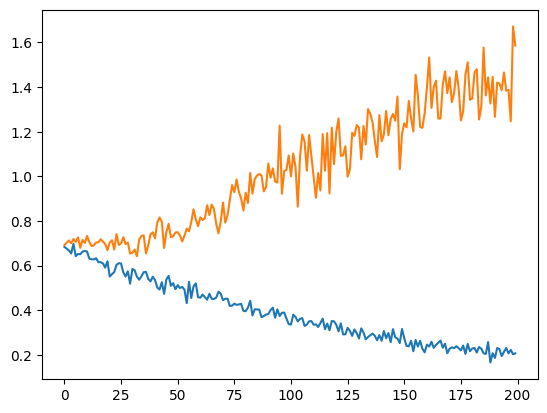

gamma


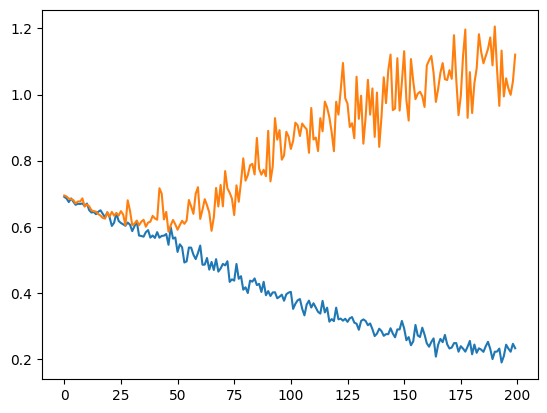

ripple


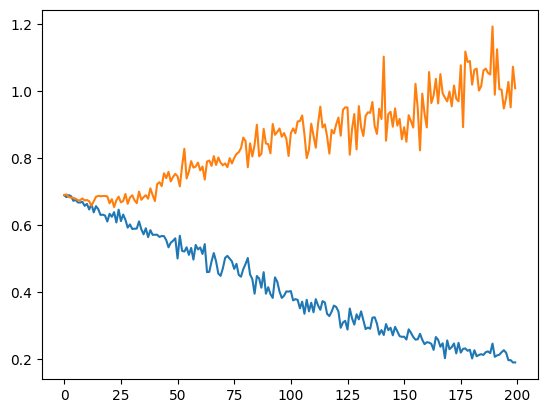

In [20]:
# 過学習強い（要修正）
models_list_sleep = []
loss_trains_list_sleep = []
loss_valids_list_sleep = []
ps_sleep = []
for mi in range(5):
    models, loss_trains, loss_valids, (p1, p2) = train(x[mi][1], sleep_target[mi], n_iter=200)
    models_list_sleep.append(models)
    loss_trains_list_sleep.append(loss_trains)
    loss_valids_list_sleep.append(loss_valids)
    
    ps_sleep.append((p1, p2))
    print(f"Mouse {mi+1}: ({p1}, {p2})")
    for oi, target in enumerate(["delta", "theta", "alpha", "beta", "gamma", "ripple"]):
        print(target)
        plt.plot(loss_trains[oi])
        plt.plot(loss_valids[oi])
        plt.show()

In [21]:
embed_sleep = [[embed(models_list_sleep[mi][oi], x[mi][1]) for oi in range(6)] for mi in range(5)]
embed_day2_sleep = [[embed(models_list_sleep[mi][oi], x[mi][2]) for oi in range(6)] for mi in range(5)]

Mouse 1: (5946, 7299)
Zone


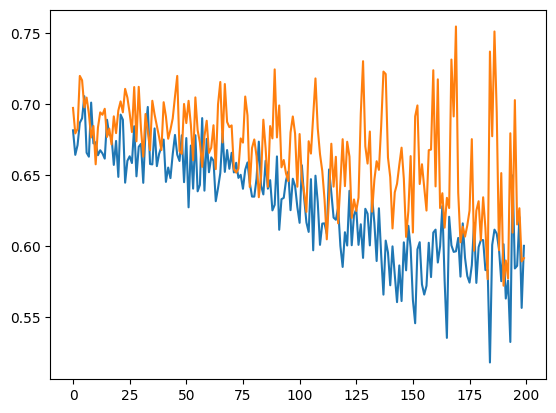

Lick


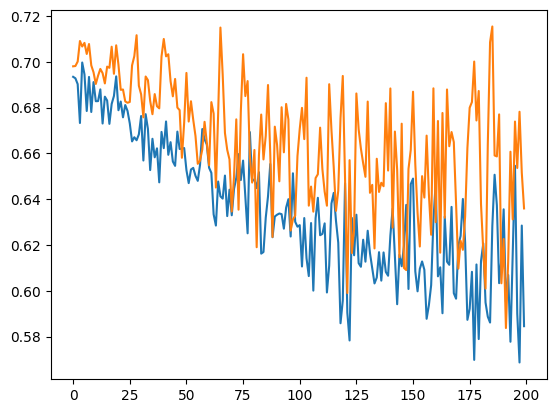

Reward


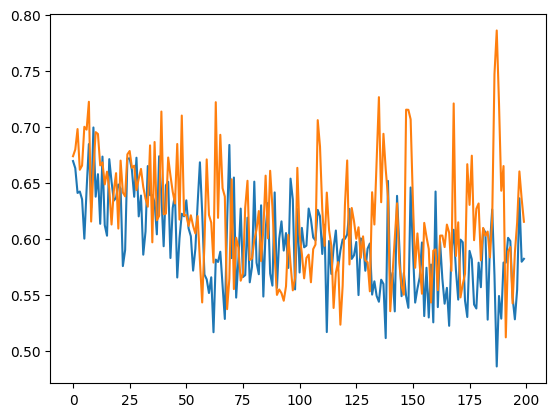

X


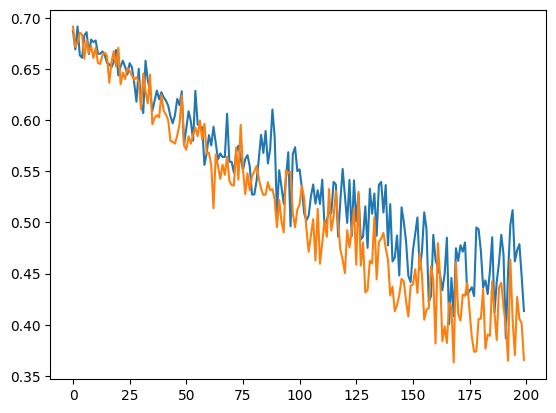

Mouse 2: (10863, 12877)
Zone


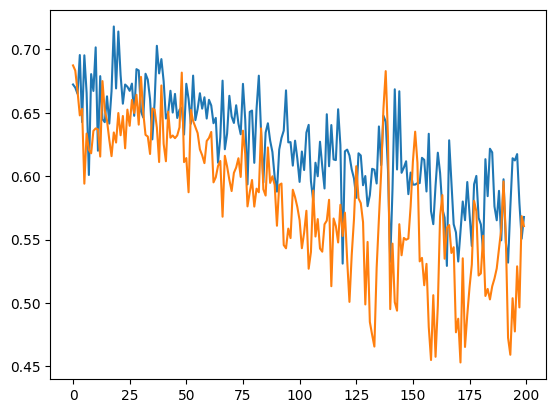

Lick


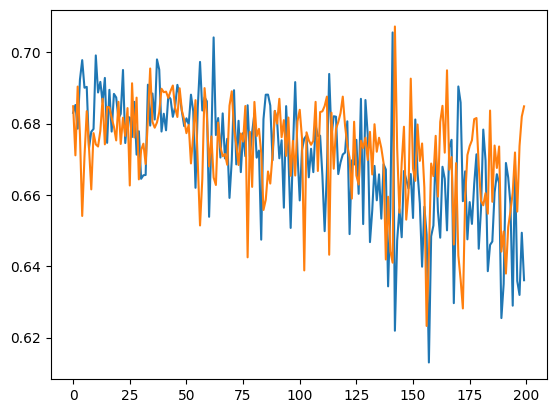

Reward


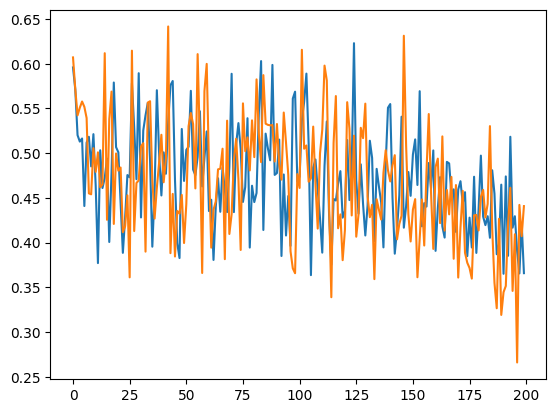

X


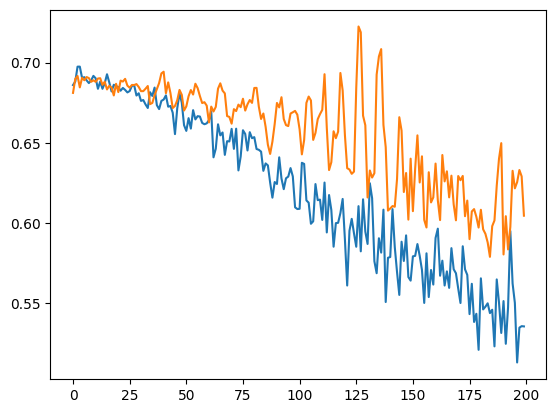

Mouse 3: (12321, 14137)
Zone


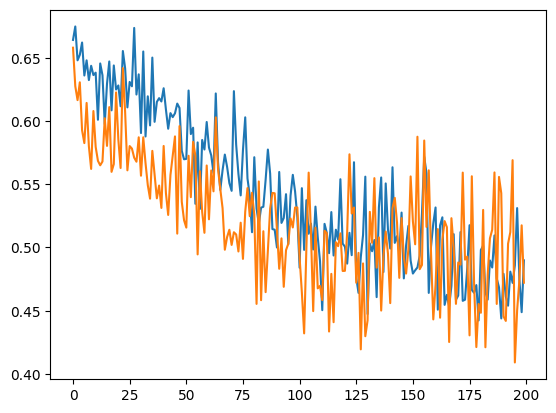

Lick


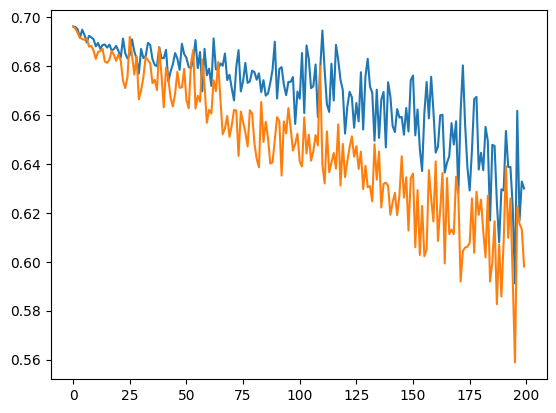

Reward


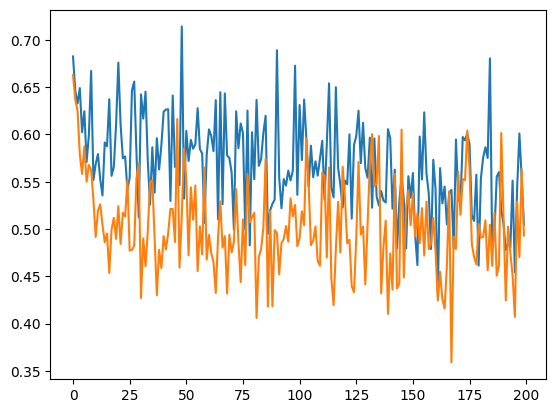

X


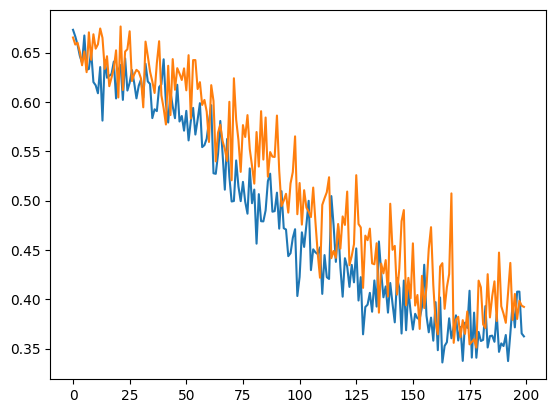

Mouse 4: (10353, 12383)
Zone


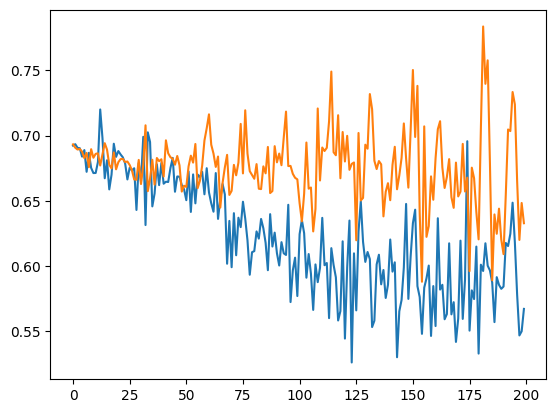

Lick


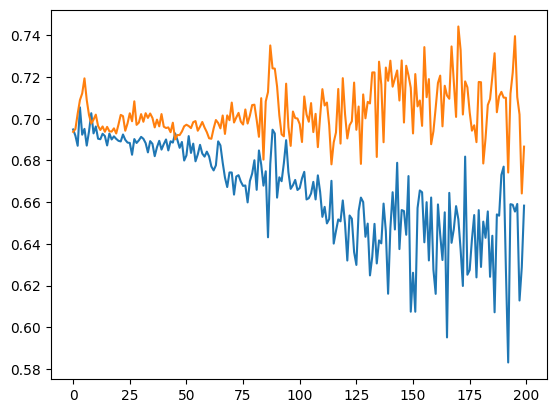

Reward


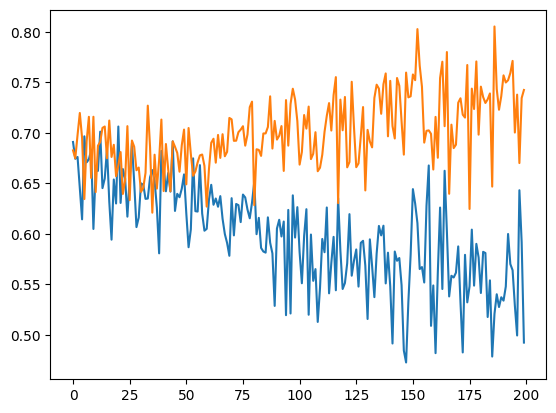

X


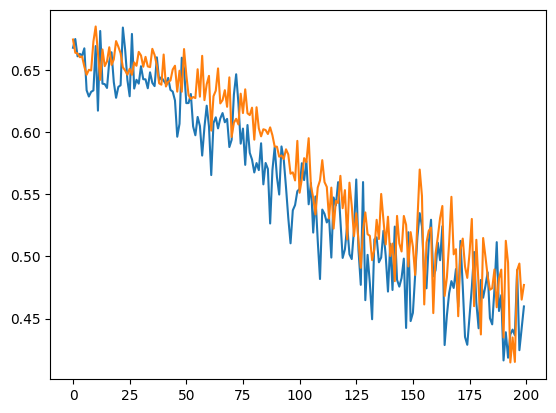

Mouse 5: (8019, 9844)
Zone


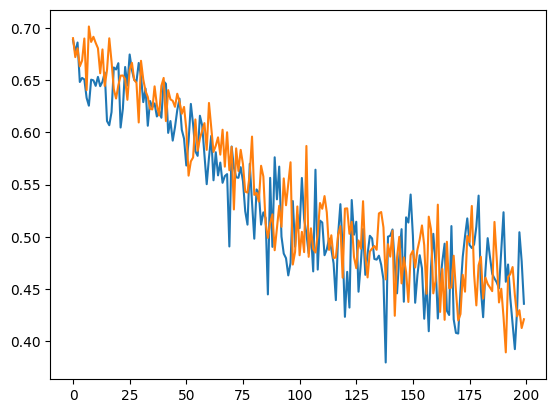

Lick


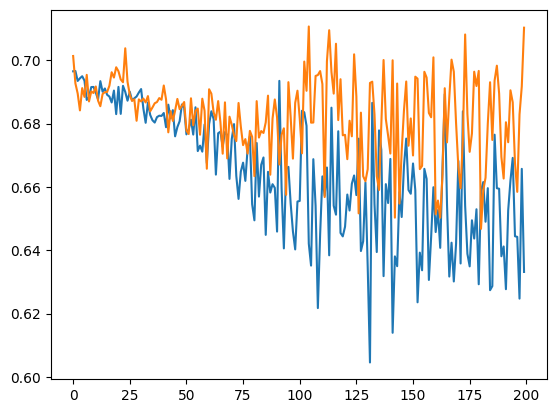

Reward


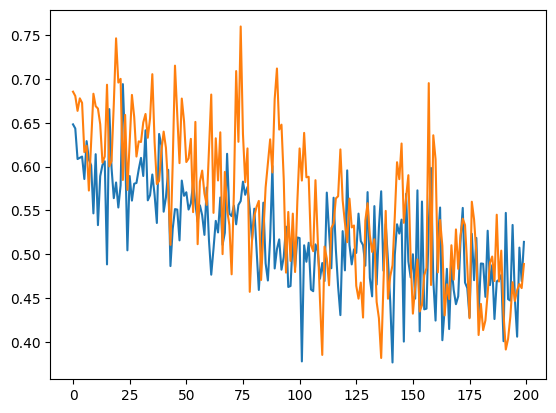

X


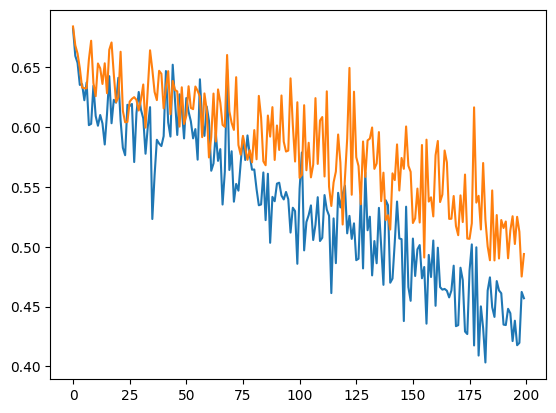

In [22]:
models_list_day2_sleep = []
loss_trains_list_day2_sleep = []
loss_valids_list_day2_sleep = []
ps_day2_sleep = []
for mi in range(5):
    models, loss_trains, loss_valids, (p1, p2) = train(np.hstack((embed_day2[mi] + embed_day2_sleep[mi])), awake_target[mi][1], n_iter=200)
    models_list_day2_sleep.append(models)
    loss_trains_list_day2_sleep.append(loss_trains)
    loss_valids_list_day2_sleep.append(loss_valids)
    
    ps_day2_sleep.append((p1, p2))
    print(f"Mouse {mi+1}: ({p1}, {p2})")
    for oi, target in enumerate(["Zone", "Lick", "Reward", "X"]):
        print(target)
        plt.plot(loss_trains[oi])
        plt.plot(loss_valids[oi])
        plt.show()

In [23]:
embed_day2_sleep_tr = [[[embed(models_list_day2_sleep[mi][oi], np.hstack((embed_day2[mj] + embed_day2_sleep[mj]))) for oi in range(4)] for mi in range(5)] for mj in range(5)]

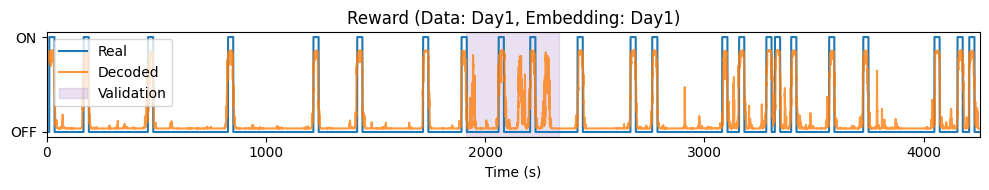

In [80]:
mi = 4
oi = 2
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(awake_target[mi][0][:, oi], label="Real")
ax.plot(embed_day1[mi][oi][:, 0], label="Decoded", alpha=0.8)
ax.axvspan(ps[mi][0], ps[mi][1], color="C4", alpha=0.2, label="Validation")
t = len(embed_day1[mi][oi])
ax.set_xlim(0, t)
ax.set_xlabel("Time (s)")
ax.set_xticks(np.arange(t // 5000 + 1) * 5000)
ax.set_xticklabels(np.arange(t // 5000 + 1) * 1000)
ax.set_title("Reward (Data: Day1, Embedding: Day1)")
ax.set_yticks([0, 1])
ax.set_yticklabels(["OFF", "ON"])
plt.legend()
plt.tight_layout()
plt.savefig("crest20250313/reward_day1_day1.png")

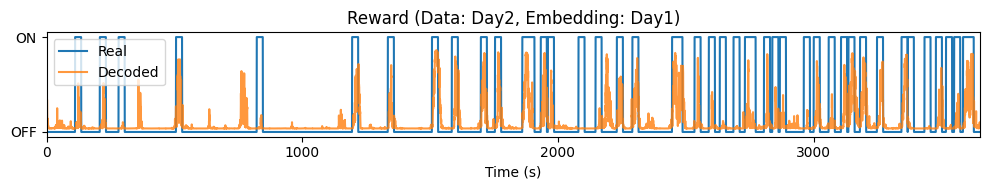

In [81]:
mi = 4
oi = 2
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(awake_target[mi][1][:, oi], label="Real")
ax.plot(embed_day2[mi][oi][:, 0], label="Decoded", alpha=0.8)
#ax.axvspan(ps_day2[mi][0], ps_day2[mi][1], color="C4", alpha=0.2, label="Validation")
t = len(embed_day2[mi][oi])
ax.set_xlim(0, t)
ax.set_xlabel("Time (s)")
ax.set_xticks(np.arange(t // 5000 + 1) * 5000)
ax.set_xticklabels(np.arange(t // 5000 + 1) * 1000)
ax.set_title("Reward (Data: Day2, Embedding: Day1)")
ax.set_yticks([0, 1])
ax.set_yticklabels(["OFF", "ON"])
plt.legend()
plt.tight_layout()
plt.savefig("crest20250313/reward_day2_day1.png")

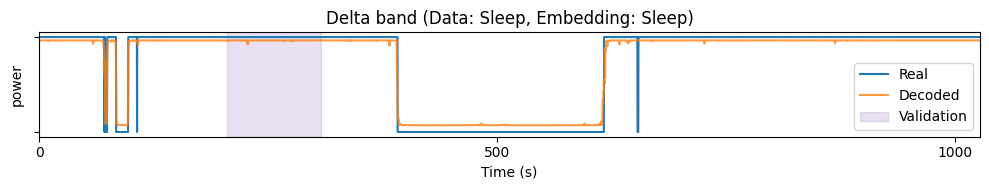

In [82]:
mi = 4
oi = 0
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(sleep_target[mi][:, oi], label="Real")
ax.plot(embed_sleep[mi][oi][:, 0], label="Decoded", alpha=0.8)
ax.axvspan(ps_sleep[mi][0], ps_sleep[mi][1], color="C4", alpha=0.2, label="Validation")
t = len(embed_sleep[mi][oi])
ax.set_xlim(0, t)
ax.set_xlabel("Time (s)")
ax.set_xticks(np.arange(t // 2500 + 1) * 2500)
ax.set_xticklabels(np.arange(t // 2500 + 1) * 500)
ax.set_title("Delta band (Data: Sleep, Embedding: Sleep)")
ax.set_ylabel("power")
ax.set_yticks([0, 1])
ax.set_yticklabels(["", ""])
plt.legend()
plt.tight_layout()
plt.savefig("crest20250313/delta_sleep.png")

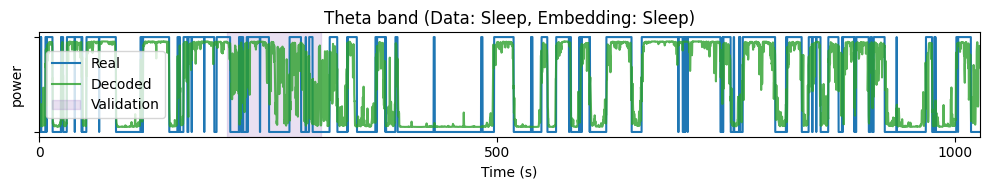

In [83]:
mi = 4
oi = 1
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(sleep_target[mi][:, oi], label="Real")
ax.plot(embed_sleep[mi][oi][:, 0], color="C2", label="Decoded", alpha=0.8)
ax.axvspan(ps_sleep[mi][0], ps_sleep[mi][1], color="C4", alpha=0.2, label="Validation")
t = len(embed_sleep[mi][oi])
ax.set_xlim(0, t)
ax.set_xlabel("Time (s)")
ax.set_xticks(np.arange(t // 2500 + 1) * 2500)
ax.set_xticklabels(np.arange(t // 2500 + 1) * 500)
ax.set_title("Theta band (Data: Sleep, Embedding: Sleep)")
ax.set_ylabel("power")
ax.set_yticks([0, 1])
ax.set_yticklabels(["", ""])
plt.legend()
plt.tight_layout()
plt.savefig("crest20250313/theta_sleep.png")

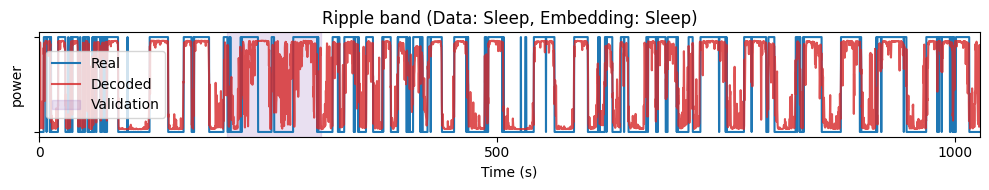

In [84]:
mi = 4
oi = 5
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(sleep_target[mi][:, oi], label="Real")
ax.plot(embed_sleep[mi][oi][:, 0], color="C3", label="Decoded", alpha=0.8)
ax.axvspan(ps_sleep[mi][0], ps_sleep[mi][1], color="C4", alpha=0.2, label="Validation")
t = len(embed_sleep[mi][oi])
ax.set_xlim(0, t)
ax.set_xlabel("Time (s)")
ax.set_xticks(np.arange(t // 2500 + 1) * 2500)
ax.set_xticklabels(np.arange(t // 2500 + 1) * 500)
ax.set_title("Ripple band (Data: Sleep, Embedding: Sleep)")
ax.set_ylabel("power")
ax.set_yticks([0, 1])
ax.set_yticklabels(["", ""])
plt.legend()
plt.tight_layout()
plt.savefig("crest20250313/ripple_sleep.png")

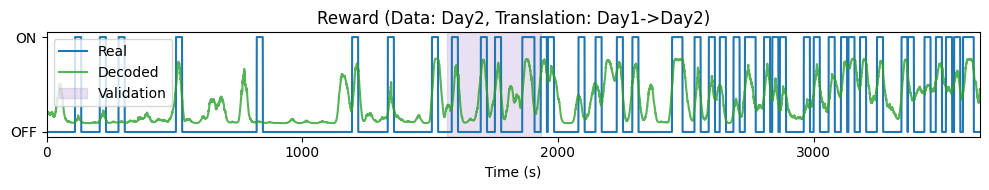

In [85]:
mi = 4
oi = 2
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(awake_target[mi][1][:, oi], label="Real")
ax.plot(embed_day2_tr[mi][mi][oi][:, 0], label="Decoded", color="C2", alpha=0.8)
ax.axvspan(ps_day2[mi][0], ps_day2[mi][1], color="C4", alpha=0.2, label="Validation")
t = len(embed_day2_tr[mi][mi][oi])
ax.set_xlim(0, t)
ax.set_xlabel("Time (s)")
ax.set_xticks(np.arange(t // 5000 + 1) * 5000)
ax.set_xticklabels(np.arange(t // 5000 + 1) * 1000)
ax.set_title("Reward (Data: Day2, Translation: Day1->Day2)")
ax.set_yticks([0, 1])
ax.set_yticklabels(["OFF", "ON"])
plt.legend()
plt.tight_layout()
plt.savefig("crest20250313/reward_day2_tr_day1.png")

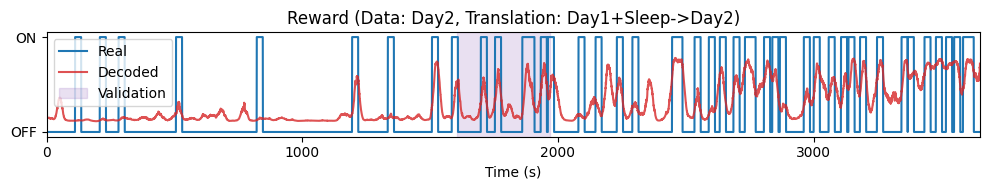

In [86]:
mi = 4
oi = 2
fig, ax = plt.subplots(figsize=(10, 2))
ax.plot(awake_target[mi][1][:, oi], label="Real")
ax.plot(embed_day2_sleep_tr[mi][mi][oi][:, 0], label="Decoded", color="C3", alpha=0.8)
ax.axvspan(ps_day2_sleep[mi][0], ps_day2_sleep[mi][1], color="C4", alpha=0.2, label="Validation")
t = len(embed_day2_sleep_tr[mi][mi][oi])
ax.set_xlim(0, t)
ax.set_xlabel("Time (s)")
ax.set_xticks(np.arange(t // 5000 + 1) * 5000)
ax.set_xticklabels(np.arange(t // 5000 + 1) * 1000)
ax.set_title("Reward (Data: Day2, Translation: Day1+Sleep->Day2)")
ax.set_yticks([0, 1])
ax.set_yticklabels(["OFF", "ON"])
plt.legend()
plt.tight_layout()
plt.savefig("crest20250313/reward_day2_tr_day1_sleep.png")

In [87]:
def closs(output, target):
    return -np.hstack((np.log(1 - output[target == 0]), np.log(output[target == 1]))).mean()

In [88]:
loss_day1 = np.array([[closs(embed_day1[mi][oi][:, 0], awake_target[mi][0][:, oi]) for oi in range(4)] for mi in range(5)])

In [89]:
loss_day2 = np.array([[closs(embed_day2[mi][oi][:, 0], awake_target[mi][1][:, oi]) for oi in range(4)] for mi in range(5)])

In [90]:
loss_day2_tr = np.array([[[closs(embed_day2_tr[mi][mj][oi][:, 0], awake_target[mi][1][:, oi]) for oi in range(4)] for mj in range(5)] for mi in range(5)])

In [91]:
loss_day2_sleep_tr = np.array([[[closs(embed_day2_sleep_tr[mi][mj][oi][:, 0], awake_target[mi][1][:, oi]) for oi in range(4)] for mj in range(5)] for mi in range(5)])

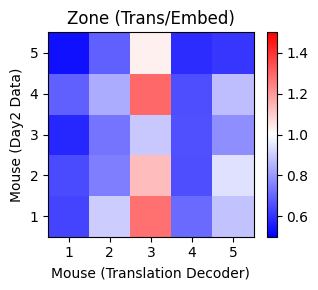

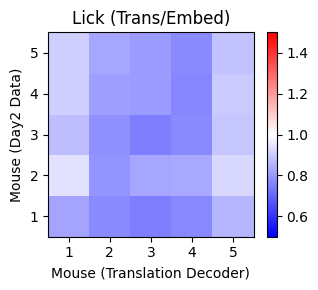

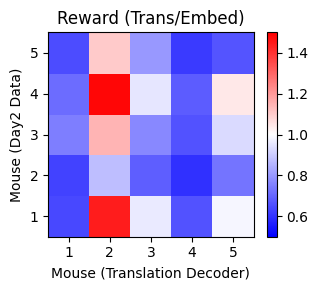

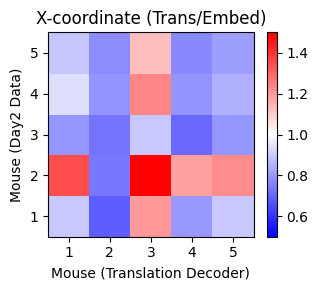

In [92]:
for oi, out in enumerate(["Zone", "Lick", "Reward", "X-coordinate"]):
    plt.figure(figsize=(3.3, 3))
    plt.pcolor((loss_day2_tr / loss_day2)[:, :, oi], vmin=0.5, vmax=1.5, cmap="bwr")
    plt.ylabel("Mouse (Day2 Data)")
    plt.xlabel("Mouse (Translation Decoder)")
    plt.xticks(np.arange(5)+0.5, np.arange(1, 6))
    plt.yticks(np.arange(5)+0.5, np.arange(1, 6))
    plt.title(f"{out} (Trans/Embed)")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f"crest20250313/{out}_matrix.png")
    plt.show()

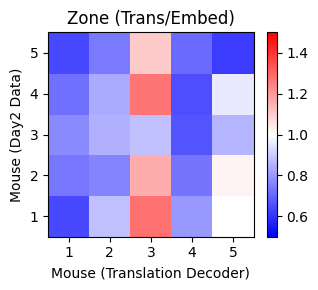

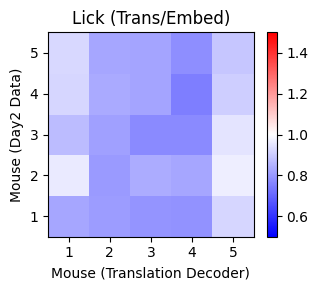

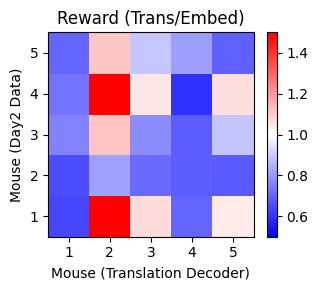

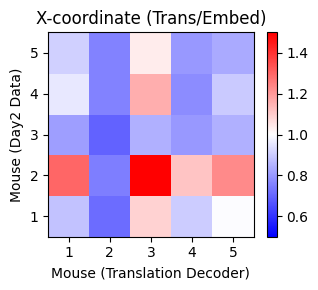

In [93]:
for oi, out in enumerate(["Zone", "Lick", "Reward", "X-coordinate"]):
    plt.figure(figsize=(3.3, 3))
    plt.pcolor((loss_day2_sleep_tr / loss_day2)[:, :, oi], vmin=0.5, vmax=1.5, cmap="bwr")
    plt.ylabel("Mouse (Day2 Data)")
    plt.xlabel("Mouse (Translation Decoder)")
    plt.xticks(np.arange(5)+0.5, np.arange(1, 6))
    plt.yticks(np.arange(5)+0.5, np.arange(1, 6))
    plt.title(f"{out} (Trans/Embed)")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(f"crest20250313/{out}_matrix_sleep.png")
    plt.show()

In [94]:
loss_day2_tr_ii = np.array([loss_day2_tr[i, i, :] for i in range(5)])

In [95]:
loss_day2_sleep_tr_ii = np.array([loss_day2_sleep_tr[i, i, :] for i in range(5)])

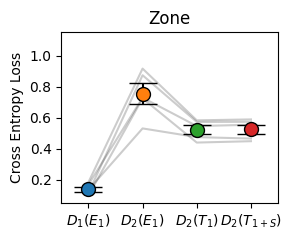

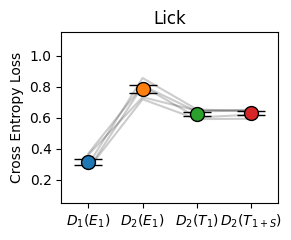

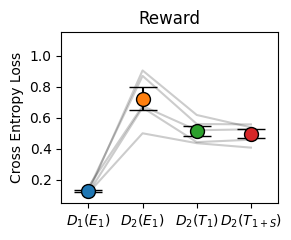

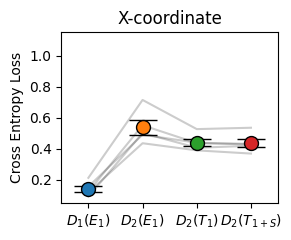

In [96]:
for oi, out in enumerate(["Zone", "Lick", "Reward", "X-coordinate"]):
    tmp = np.vstack((
        loss_day1[:, oi],
        loss_day2[:, oi],
        loss_day2_tr_ii[:, oi],
        loss_day2_sleep_tr_ii[:, oi]
    ))
    plt.figure(figsize=(3, 2.5))
    plt.plot(tmp, color="k", alpha=0.2)
    for i in range(4):
        plt.errorbar(i, tmp[i, :].mean(), yerr=stats.sem(tmp[i, :]), fmt="o", ecolor="k", markeredgecolor="k", markersize=10, capsize=10)
    plt.xticks([0, 1, 2, 3], ["$D_1(E_1)$", "$D_2(E_1)$", "$D_2(T_1)$", "$D_2(T_{1+S})$"])
    plt.xlim(-0.5, 3.5)
    plt.ylim(0.05, 1.15)
    plt.ylabel("Cross Entropy Loss")
    plt.title(out)
    plt.tight_layout()
    plt.savefig(f"crest20250313/{out}_errorbar.png")
    plt.show()